# Chapter 7 - Imaging and Diffraction Limited Imaging Simulation


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, fft, ifft, ifftshift

# Define the rect function
def rect(x):
    return np.where(np.abs(x) <= 0.5, 1, 0)

def comb(x):
    # Dirac delta approximation: 1 where x is an integer, 0 otherwise
    return np.where(np.abs(x - np.round(x)) < 3e-2, 1, 0)

def circ_(x, y, r):
    return np.where(np.sqrt(x**2 + y**2) <= r, 1, 0)

def sinc(x):
    return np.where(x == 0, 1, np.sin(x) / x)

def triangle(x):
    return np.where(np.abs(x) <= 1, 1 - np.abs(x), 0)

def gauss(x):
    return np.exp(-x**2)

def circ(r):
    return lambda x, y: np.where(np.sqrt(x**2 + y**2) <= r, 1, 0)

def propTF(u1, L, lamda, z):
    M, N = np.shape(u1)
    dx = L / M
    k = 2 * np.pi / lamda

    fx = np.linspace(-M/(2*L), M/(2*L), M) ; fy = fx
    FX, FY = np.meshgrid(fx, fy)


    H = np.exp(-1j* np.pi * lamda * z * (FX **2 + FY **2))
    H = fftshift(H)
    U1 = fft2(fftshift(u1))
    U2 = H* U1
    u2 = ifftshift(ifft2(U2))
    return u2

def propIR(u1,L,lamda,z):
    M, N = np.shape(u1)
    dx = L / M
    k = 2 * np.pi / lamda

    x = np.linspace(-L/2, L/2, M) ; y = x
    X, Y = np.meshgrid(x, y)

    h = 1 / (1j * lamda * z) * np.exp(1j * k / (2 * z) * (X ** 2 + Y ** 2))
    H = fft2(fftshift(h)) * dx ** 2
    U1 = fft2(fftshift(u1))
    U2 = H*U1
    u2 = ifftshift(ifft2(U2))

    return u2

def propFF(u1, L1, lambda_, z):
    """
    Propagation - Fraunhofer pattern
    Assumes uniform sampling

    Parameters:
    u1 : ndarray - Source plane field
    L1 : float - Source plane side length
    lambda_ : float - Wavelength
    z : float - Propagation distance

    Returns:
    u2 : ndarray - Observation plane field
    L2 : float - Observation plane side length
    """
    M, N = u1.shape  # Get input field array size
    dx1 = L1 / M  # Source sample interval
    k = 2 * np.pi / lambda_  # Wavenumber

    L2 = lambda_ * z / dx1  # Observation side length
    dx2 = lambda_ * z / L1  # Observation sample interval
    x2 = np.arange(-L2 / 2, L2 / 2, dx2)  # Observation coordinates

    X2, Y2 = np.meshgrid(x2, x2)  # Create 2D grid of observation coordinates
    c = 1 / (1j * lambda_ * z) * np.exp(1j * k / (2 * z) * (X2**2 + Y2**2))
    u2 = c * np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(u1))) * dx1**2

    return u2, L2


## 7.2 Coherent Imaging

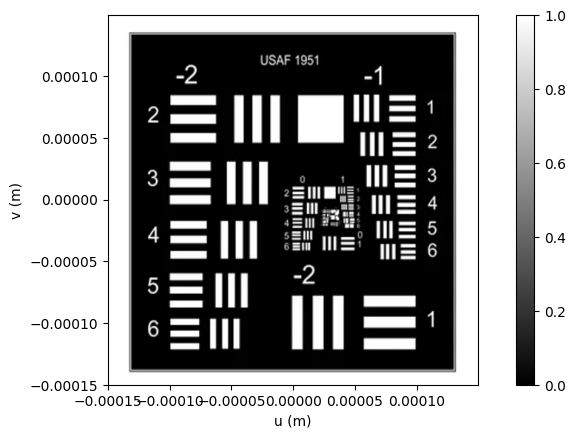

In [ ]:
################################################################

#                 Coherent Imaging Example

################################################################

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Step 3: Read the image file
A = Image.open('USAF1951.png').convert('L').resize((500,500)) # Ensure the file path and name are correct

# Step 4: Get image size
M, N = A.size

# Step 5: Reverse row order
A = A.transpose(Image.FLIP_TOP_BOTTOM)

# Step 6: Convert integer to floating point
Ig = np.array(A, dtype=np.float32)

# Step 7: Normalize the image
Ig /= Ig.max()

# Step 9: Compute the ideal image field
ug = np.sqrt(Ig)

# Step 10: Define image plane side length
L = 0.3e-3  # meters

# Step 11: Compute the sample interval
du = L / M

# Step 12: Define coordinates
u = np.linspace(-L / 2, L / 2 - du, M)
v = u  # Assuming square image for simplicity

# Steps 14-18: Plotting the image
plt.figure()
plt.imshow(Ig, extent=(u.min(), u.max(), v.min(), v.max()), cmap='gray', origin='lower')
plt.colorbar()
plt.xlabel('u (m)')
plt.ylabel('v (m)')
plt.axis('square')
plt.show()


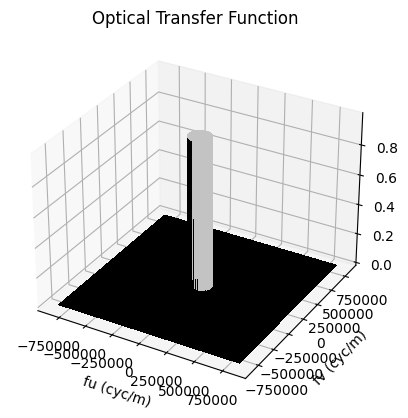

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

# Constants
lambda_ = 0.5e-6  # Wavelength in meters
wxp = 6.25e-3     # Exit pupil radius in meters
zxp = 125e-3      # Exit pupil distance in meters
f0 = wxp / (lambda_ * zxp)  # Cutoff frequency

# Step 10 from the previous example for du and L
L = 0.3e-3  # image plane side length from previous context
M = 500    # number of samples from previous context
du = L / M

# Frequency coordinates
fu = np.arange(-1/(2*du), 1/(2*du), 1/L)
fv = fu
Fu, Fv = np.meshgrid(fu, fv)

# Circular aperture function
def circ(r):
    return (r <= 1).astype(float)

# Compute the transfer function H
radius = np.sqrt(Fu**2 + Fv**2) / f0
H = circ(radius)

# Visualizing the transfer function H
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ls = LightSource(azdeg=0, altdeg=65)  # Emulate MATLAB's camlight
rgb = ls.shade(H * 0.99, plt.cm.gray)  # Apply shading to grayscale
ax.plot_surface(Fu, Fv, H * 0.99, rstride=1, cstride=1, facecolors=rgb, linewidth=0, antialiased=False)
ax.set_xlabel('fu (cyc/m)')
ax.set_ylabel('fv (cyc/m)')
ax.set_title('Optical Transfer Function')
plt.show()


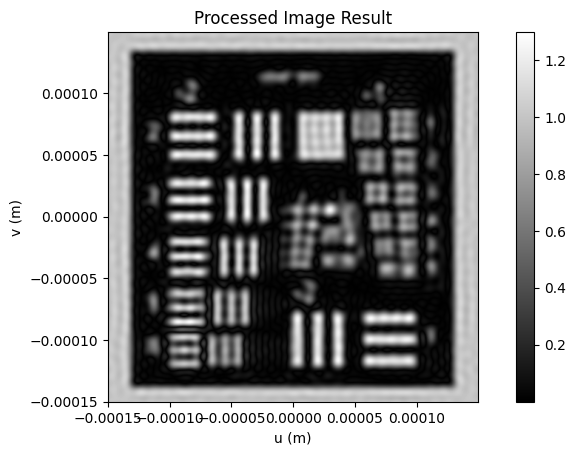

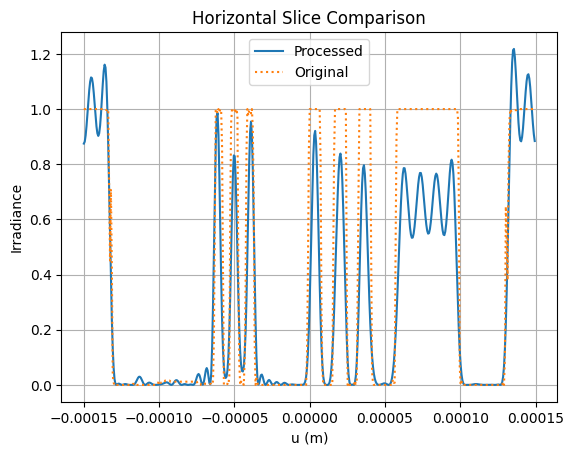

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assumed previous variables and import statements are in place

# Apply the Optical Transfer Function
H = np.fft.fftshift(H)
Gg = np.fft.fft2(np.fft.fftshift(ug))
Gi = Gg * H
ui = np.fft.ifftshift(np.fft.ifft2(Gi))
Ii = np.abs(ui) ** 2

# Image result visualization
plt.figure()
plt.imshow(np.power(Ii, 0.5), extent=[u.min(), u.max(), v.min(), v.max()], cmap='gray', origin='lower')
plt.colorbar()
plt.xlabel('u (m)')
plt.ylabel('v (m)')
plt.title('Processed Image Result')
plt.axis('square')
plt.show()

# Horizontal image slice
vvalue = -0.8e-4  # specific y value
vindex = int(round(vvalue / du + (M / 2 + 1)))  # convert y value to row index

plt.figure()
plt.plot(u, Ii[vindex, :], label='Processed')
plt.plot(u, Ig[vindex, :], ':', label='Original')
plt.xlabel('u (m)')
plt.ylabel('Irradiance')
plt.title('Horizontal Slice Comparison')
plt.legend()
plt.grid(True)
plt.show()


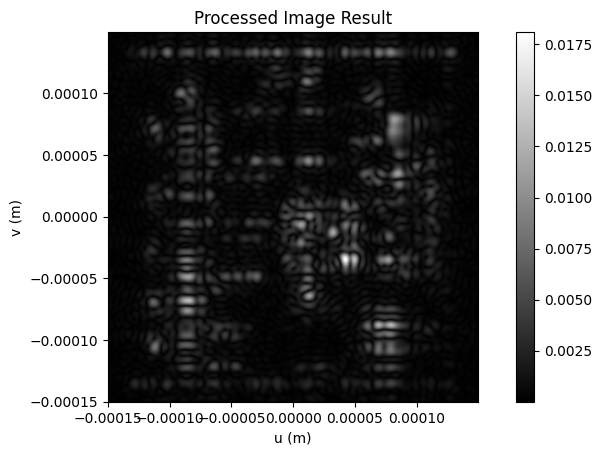

In [ ]:
################################################################

#                 Coherent Imaging Example

################################################################

import numpy as np
import matplotlib.pyplot as plt

# Step 3: Read the image file
A = Image.open('USAF1951.png').convert('L').resize((500,500)) # Ensure the file path and name are correct

# Step 4: Get image size
M, N = A.size

# Step 5: Reverse row order
A = A.transpose(Image.FLIP_TOP_BOTTOM)

# Step 6: Convert integer to floating point
Ig = np.array(A, dtype=np.float32)

# Step 7: Normalize the image
Ig /= Ig.max()

# Assumed previous variables and import statements are in place

# Apply the Optical Transfer Function
ug = np.sqrt(Ig)*np.exp(1j*2*np.pi*np.random.rand(M)) #### we add this line (To create spackle pattern) ###
H = np.fft.fftshift(H)
Gg = np.fft.fft2(np.fft.fftshift(ug))
Gi = Gg * H
ui = np.fft.ifftshift(np.fft.ifft2(Gi))
Ii = np.abs(ui) ** 2

# Image result visualization
plt.figure()
plt.imshow(np.power(Ii, 0.5), extent=[u.min(), u.max(), v.min(), v.max()], cmap='gray', origin='lower')
plt.colorbar()
plt.xlabel('u (m)')
plt.ylabel('v (m)')
plt.title('Processed Image Result')
plt.axis('square')
plt.show()

## 7.3 Incoherent Imaging


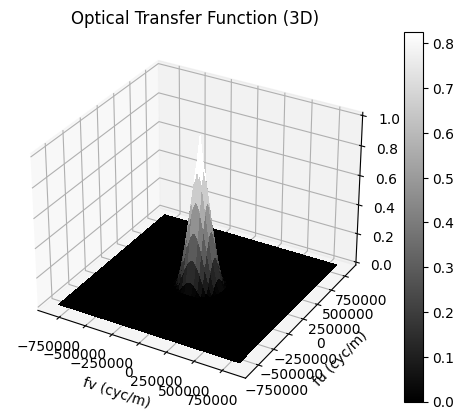

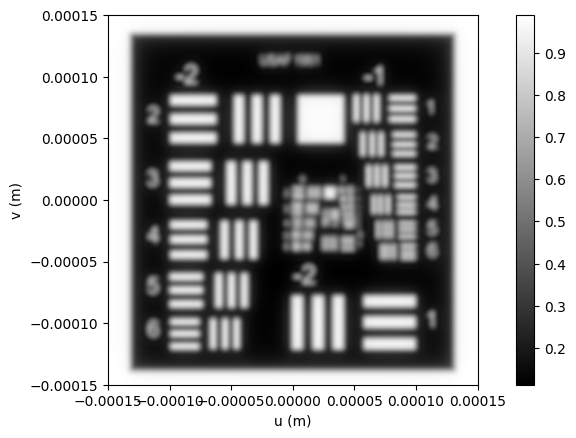

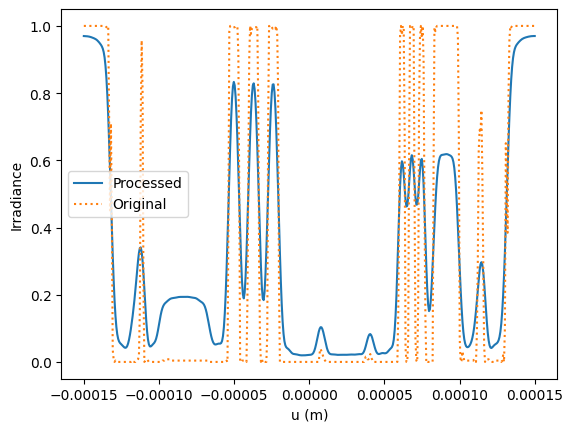

In [ ]:
#################################################################

# Incoherent Imaging Example

#################################################################


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Step 3: Read the image file
A = Image.open('USAF1951.png').convert('L').resize((500,500))  # Ensure the file is in grayscale

# Step 4: Get image size and process the image
M, N = A.size
A = np.array(A)[::-1]  # Flip the image vertically
Ig = A.astype(np.float32)
Ig /= Ig.max()  # Normalize the image

# Define constants
L = 0.3e-3  # meters
du = L / M
u = np.linspace(-L / 2, L / 2, M)
v = u

# Optical system parameters
lambda_ = 0.5e-6  # Wavelength in meters
wxp = 6.25e-3     # Exit pupil radius in meters
zxp = 125e-3      # Exit pupil distance in meters
f0 = wxp / (lambda_ * zxp)  # Coherent cutoff frequency

# Frequency coordinates
fu = np.linspace(-M/(2*L), M/(2*L), M)#np.fft.fftfreq(M, du)
fv = fu
Fu, Fv = np.meshgrid(fu, fv)

# Optical transfer function (OTF)
radius = np.sqrt(Fu**2 + Fv**2) / f0
H = circ(f0)(Fu,Fv)
OTF = np.fft.ifft2(np.abs(np.fft.fft2(np.fft.fftshift(H)))**2)
OTF = np.abs(OTF / OTF[0, 0])

# Plotting the OTF using a 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fu_sorted_indices = np.argsort(fu)
fv_sorted_indices = np.argsort(fv)
fu_sorted = fu[fu_sorted_indices]
fv_sorted = fv[fv_sorted_indices]
OTF_sorted = OTF[np.ix_(fu_sorted_indices, fv_sorted_indices)]

Fu, Fv = np.meshgrid(fu_sorted, fv_sorted)
surf = ax.plot_surface(Fu, Fv, np.fft.fftshift(OTF_sorted), cmap='gray', linewidth=0, antialiased=False)
fig.colorbar(surf)
ax.set_xlabel('fv (cyc/m)')
ax.set_ylabel('fu (cyc/m)')
ax.set_zlabel('OTF Magnitude')
plt.title('Optical Transfer Function (3D)')
plt.show()

# Convolution with OTF
Gg = np.fft.fft2(np.fft.fftshift(Ig))
Gi = Gg * OTF
Ii = np.fft.ifftshift(np.fft.ifft2(Gi))
Ii = np.real(Ii)  # Remove residual imaginary parts
Ii = np.maximum(Ii, 0)  # Remove values < 0

# Image result
plt.figure()
plt.imshow(np.sqrt(Ii), extent=(u.min(), u.max(), v.min(), v.max()), cmap='gray', origin='lower')
plt.colorbar()
plt.xlabel('u (m)')
plt.ylabel('v (m)')
plt.axis('square')
plt.show()

# Horizontal image slice
vvalue = 0.2e-4
vindex = int(round(vvalue / du + (M / 2)))
plt.figure()
plt.plot(u, Ii[vindex, :], label='Processed')
plt.plot(u, Ig[vindex, :], ':', label='Original')
plt.xlabel('u (m)')
plt.ylabel('Irradiance')
plt.legend()
plt.show()
